In [1]:
import os, string

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation
from shapely.ops import cascaded_union

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'
path_to_input     = '/Users/Guille/Desktop/india_power/input_data_2022/'
path_to_data      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/data/'
path_to_load      = '/Users/Guille/Desktop/india_power/input_data_2022/load'

In [2]:
# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_transfers(scen_labels_):

    def __load_tx_losses_from_csv(df_, scenario):
        
        # df_['transmission_losses_lz_to']   = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_to'] 
        # df_['transmission_losses_lz_from'] = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_from']
        df_['transmission_flow_mw']        = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_flow_mw']

#         df_1_               = df_[['period', 'load_zone_to', 'transmission_losses_lz_to']].copy()
#         df_1_['technology'] = 'Tx_Losses'
#         df_1_               = df_1_.rename(columns = {'transmission_losses_lz_to': 'power_mw', 
#                                                       'load_zone_to': 'load_zone'})

#         df_2_               = df_[['period', 'load_zone_from', 'transmission_losses_lz_from']].copy()
#         df_2_['technology'] = 'Tx_Losses'
#         df_2_               = df_2_.rename(columns = {'transmission_losses_lz_from': 'power_mw',
#                                                       'load_zone_from': 'load_zone'})
        
        df_3_ = df_[['period', 'load_zone_to', 'transmission_flow_mw']].copy()
        df_3_ = df_3_.rename(columns = {'transmission_flow_mw': 'power_mw',
                                        'load_zone_to': 'load_zone'})

        df_3_.loc[df_3_['power_mw'] >= 0., 'technology'] = 'Import'
        df_3_.loc[df_3_['power_mw'] < 0., 'technology']  = 'Export'
        
        df_4_ = df_[['period', 'load_zone_from', 'transmission_flow_mw']].copy()
        df_4_ = df_4_.rename(columns = {'transmission_flow_mw': 'power_mw',
                                        'load_zone_from': 'load_zone'})

        df_4_['power_mw'] = - df_4_['power_mw']

        df_4_.loc[df_4_['power_mw'] >= 0., 'technology'] = 'Import'
        df_4_.loc[df_4_['power_mw'] < 0., 'technology']  = 'Export'
        
        df_ = pd.concat([df_3_, df_4_], axis = 0)
        
        df_.loc[df_['load_zone'] == 'Daman_Diu', 'load_zone'] = 'Dadra_Nagar_Haveli'

        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)

        df_['scenario'] = scenario
        
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name   = r'{}/{}'.format(path, scen)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_tx_losses_from_csv(tx_losses_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_net_transfers(scen_labels_):

    def __load_net_tx_from_csv(df_, scenario):
        
        df_['transmission_flow_mw'] = df_['number_of_hours_in_timepoint'] * df_['timepoint_weight'] * df_['transmission_flow_mw']

    
        df_p_ = df_[['transmission_line', 'period', 'load_zone_to', 'load_zone_from', 'transmission_flow_mw']].copy()
        df_p_['transmission_line'] = df_p_['transmission_line'].str.replace('_new', '')

        df_p_.loc[df_p_['load_zone_to'] == 'Daman_Diu', 'load_zone_to'] = 'Dadra_Nagar_Haveli'
        df_p_.loc[df_p_['load_zone_from'] == 'Daman_Diu', 'load_zone_from'] = 'Dadra_Nagar_Haveli'

        df_p_['transmission_line'] = df_p_['transmission_line'].str.replace('Daman_Diu', 'Dadra_Nagar_Haveli')

        df_p_ = df_p_.groupby(['transmission_line', 
                               'period', 
                               'load_zone_to', 
                               'load_zone_from']).agg({'transmission_flow_mw': 'sum'}).reset_index(drop = False)

        df_p_['scenario'] = scenario
        
        return df_p_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name   = r'{}/{}'.format(path, scen)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_net_tx_from_csv(tx_losses_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_transmission_capacity(scen_labels_):

    def __load_tx_from_csv(df_, scenario):
        
        df_p_ = df_[['transmission_line', 'period', 'max_mw']].copy()
        
        idx_                       = df_p_['transmission_line'].str.contains('_new')
        df_p_['status']            = 'existing'
        df_p_.loc[idx_, 'status']  = 'new'
        df_p_['transmission_line'] = df_p_['transmission_line'].str.replace('_new', '')
        
        df_p_ = df_p_.groupby(['transmission_line', 'period', 'status']).agg({'max_mw': 'sum'}).reset_index(drop = False)

        df_p_['scenario'] = scenario
        
        return df_p_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        
        dir_name   = r'{}/{}'.format(path, scen)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_period.csv', low_memory = False)
        
        dfs_ += [__load_tx_from_csv(tx_losses_, scen)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

# Grab data from databases for plotting new and existing capacity
def _load_state_capacity(scen_labels_):

    # Load project capacity table and process them from database
    def __load_state_capacity_csv(df_, scenario):

        df_p_ = df_[['period', 'technology', 'load_zone', 'capacity_mw', 'energy_capacity_mwh']].copy()
        
        # df_['capacity_mw']         = df_['capacity_mw'].astype(float)
        # df_['energy_capacity_mwh'] = df_['energy_capacity_mwh'].astype(float)
        
        df_p_.loc[df_p_['load_zone'] == 'Daman_Diu', 'load_zone'] = 'Dadra_Nagar_Haveli'

        df_p_ = df_p_.groupby(['period', 'technology', 'load_zone']).agg({'capacity_mw': 'sum', 
                                                                          'energy_capacity_mwh': 'sum'})

        df_p_ = df_p_.reset_index(drop = False).rename(columns = {'energy_capacity_mwh': 'capacity_mwh'})

        df_p_['scenario'] = scenario

        return df_p_
    
    def __load_tx_from_csv(df_, scenario):
        
        df_p_ = df_[['tx_capacity_type', 'load_zone_from', 'load_zone_to', 'period', 'max_mw']].copy()
        df_p_ = df_p_.loc[df_p_['tx_capacity_type'] == 'tx_new_lin'].reset_index(drop = False)
        df_p_ = df_p_[['load_zone_from', 'load_zone_to', 'period', 'max_mw']]
        df_p_ = df_p_.loc[df_p_['max_mw'] > 0].reset_index(drop = False)

        df_p_.loc[df_p_['load_zone_to'] == 'Daman_Diu', 'load_zone_to'] = 'Dadra_Nagar_Haveli'
        df_p_.loc[df_p_['load_zone_from'] == 'Daman_Diu', 'load_zone_from'] = 'Dadra_Nagar_Haveli'

        df_p_['scenario'] = scenario
        
        return df_p_
    
    dfs_1_ = []
    dfs_2_ = []

    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'],  scen_labels_['path']):
        print(scen, path)
        dir_name  = r'{}/{}'.format(path, scen)
        capacity_ = pd.read_csv(dir_name + r'/results/project_period.csv', low_memory = False)
        tx_       = pd.read_csv(dir_name + r'/results/transmission_period.csv', low_memory = False)
        
        # Load specified capacity from csv files
        dfs_1_.append(__load_state_capacity_csv(capacity_, scen))
        dfs_2_.append(__load_tx_from_csv(tx_, scen))

    return pd.concat(dfs_1_, axis = 0).reset_index(drop = True), pd.concat(dfs_2_, axis = 0).reset_index(drop = True)

def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    capacity_ = capacity_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'scenario']).agg({'capacity_mw': 'sum', 
                                                     'capacity_mwh': 'sum'})

    return capacity_.reset_index(drop = False)

In [3]:
def _opt_dist(x_, y_, d = 1.4, delta = 0.1):
    
    def __update_position(x, x_0, z):
        return x + ((x - x_0)/z)*delta, x_0 + ((x_0 - x)/z)*delta  
    
    while True:
        flag = True
        for i in range(x_.shape[0]):
            for j in range(x_.shape[0]):
                if i != j:
                    z = np.sqrt( (x_[j] - x_[i])**2 + (y_[j] - y_[i])**2 )
                    if z < d:
                        x_[j], x_[i] = __update_position(x_[j], x_[i], z)
                        y_[j], y_[i] = __update_position(y_[j], y_[i], z)
                        flag = False
        if flag:
            break

    return x_, y_

_map = gpd.read_file(path_to_data + r"map/india-polygon.shp").to_crs("epsg:4326")
#_map = _map.drop([0, 15])

_nothern      = _map.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")
_northeastern = _map.loc[[1, 2, 18, 19, 20, 21, 29]].dissolve()
_western      = _map.loc[[5, 6, 7, 8, 9, 16, 17]].dissolve()
_southern     = _map.loc[[13, 14, 23, 27, 28, 34]].dissolve()
_eastern      = _map.loc[[3, 12, 26, 32, 33]].dissolve()
_regions      = pd.concat([_northeastern, _western, _southern, _eastern], axis = 0)

city_ = pd.read_csv(path_to_input + r"transmission/major_cities_india.csv")
city_ = city_.drop(columns = ['state', 'major_city'])
city_ = city_.rename(columns = {'acronym': 'load_zone_abr'})
city_ = city_.drop([28, 34, 35]).reset_index(drop = True)

load_zones_ = pd.read_csv(path_to_input + r"/india_zones.csv")
load_zones_ = load_zones_.drop(columns = ['state', 'rps_zone'])

load_zones_ = load_zones_.drop([3, 8, 35, 36]).reset_index(drop = True)
load_zones_ = pd.merge(city_, load_zones_, on  = 'load_zone_abr', 
                                           how = 'inner')
load_zones_p_ = load_zones_.copy()

load_zones_p_['longitude'], load_zones_p_['latitude'] = _opt_dist(load_zones_p_['longitude'].to_numpy(), 
                                                                  load_zones_p_['latitude'].to_numpy())
               
# load_zones_p_.loc[30, 'longitude'] += .7
load_zones_p_.loc[29, 'latitude'] += .15
print(load_zones_p_)

   load_zone_abr         region   latitude  longitude           load_zone
0             AP       Southern  17.704167  83.297778      Andhra_Pradesh
1             AR  North-Eastern  27.398913  93.594569   Arunachal_Pradesh
2             AS  North-Eastern  26.560107  91.648131               Assam
3             BR        Eastern  25.600000  85.100000               Bihar
4             CG        Central  21.250000  81.630000        Chhattisgarh
5             GA        Western  15.398056  73.811111                 Goa
6             GJ        Western  23.030000  72.580000             Gujarat
7             HR       Northern  27.684292  77.619233             Haryana
8             HP       Northern  31.778866  77.441151    Himachal_Pradesh
9             JH        Eastern  22.792500  86.184167           Jharkhand
10            KA       Southern  12.978889  77.591667           Karnataka
11            KL       Southern   8.487500  76.952500              Kerala
12            MP        Central  22.71

<ipython-input-3-1e92e6c9f740>:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  _nothern      = _map.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")


In [4]:
def _plot_transmission_exchange(ax, df_, load_zones_, period, sceneario):
    
    def __f(x):
        return np.sqrt(np.absolute(x)/5e6)

    df_p_ = df_.loc[(df_['scenario'] == sceneario) & (df_['period'] == period)].reset_index(drop = True)

    for i in range(df_p_.shape[0]):
        load_zone_to_   = load_zones_.loc[load_zones_['load_zone'] == df_p_.loc[i, 'load_zone_to']]
        load_zone_from_ = load_zones_.loc[load_zones_['load_zone'] == df_p_.loc[i, 'load_zone_from']]

        x_ = np.concatenate([load_zone_from_['latitude'].to_numpy(), load_zone_to_['latitude'].to_numpy()], axis = 0)
        y_ = np.concatenate([load_zone_from_['longitude'].to_numpy(), load_zone_to_['longitude'].to_numpy()], axis = 0)

        exchange = df_p_.loc[i, 'transmission_flow_mw']

        z = __f(exchange)
        w = np.sign(exchange)

        line = ax.plot(y_, x_, 
                       lw             = 1 + z, 
                       zorder         = 10, 
                       color          = '#136564', 
                       solid_capstyle = 'round', 
                       alpha          = .675)

        l = .2 + np.sqrt(z)/4

        dy = (y_[1] - y_[0])/2.
        dx = (x_[1] - x_[0])/2.
        ds = np.sqrt(dy**2 + dx**2)
        lx = dx/ds
        ly = dy/ds
        if w > 0:
            ax.arrow(y_[0] + dy, x_[0] + dx, ly*l, lx*l, 
                     overhang   = 0.25, 
                     shape      = 'left', 
                     color      = '#136564',
                     ls         = 'None', 
                     head_width = l, 
                     zorder     = 11, 
                     alpha      = .675,
                     length_includes_head = True)
        else:
            ax.arrow(y_[0] + dy, x_[0] + dx, -ly*l, -lx*l, 
                     overhang   = 0.25, 
                     shape      = 'right', 
                     color      = '#136564',
                     ls         = 'None', 
                     head_width = l, 
                     zorder     = 11, 
                     alpha      = .675,
                     length_includes_head = True)

    _nothern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _northeastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _western.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _southern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _eastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _map.plot(ax = ax, zorder = 8, color = 'lightgray', lw = 0.5, edgecolor = 'white')
    
    # #95cca3 #2cb7b5
    line1 = Line2D([], [], color = '#136564', lw = __f(2500000), solid_capstyle ='round')
    line2 = Line2D([], [], color = '#136564', lw = __f(50000000), solid_capstyle ='round')
    line3 = Line2D([], [], color = '#136564', lw = __f(100000000), solid_capstyle ='round')
    line4 = Line2D([], [], color = '#136564', lw = __f(200000000), solid_capstyle ='round')

    ax.legend((line1, line2, line3, line4), ('25', '50', '100', '200'), 
               title_fontsize = 22,
               title          = 'Net Transfers (TWh)',
               handlelength   = 5.,
               handletextpad  = 1.,
               labelspacing   = .5,
               frameon        = False, 
               bbox_to_anchor = (0.475, 0.925), 
               prop           = {'size': 20})

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.set_xticks([], [])
    ax.set_yticks([], [])
    
def _plot_transmission_capacity(ax, df_, scen_labels_, legend_title = 'Scenarios',
                                                       ylabel       = 'Transmission Capacity (GW)',
                                                       units        = 1e3, 
                                                       legend       = True):
    
    df_ = df_.groupby(['period', 'scenario', 'status']).agg('sum').reset_index(drop = False)

    scens_   = scen_labels_['scenario']
    periods_ = df_['period'].unique()

    # techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    # colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()
    
    width = 1./(len(scens_) + 1)
    x_    = np.linspace(0, len(periods_) - 1, len(periods_))

    ticks_ = []

    for scen, i_scen in zip(scens_, range(len(scens_))):
        color = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0]
        label = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]

        for period, i_period in zip(periods_, range(len(periods_))):
            idx_ = (df_['scenario'] == scen) & (df_['period'] == period) & (df_['status'] == 'existing')
            
            y_spec = df_.loc[idx_, 'max_mw'].to_numpy()[0]

            ax.bar(x_[i_period], y_spec/units, width, 
                   color  = color, 
                   hatch  = 'x',
                   zorder = 2,
                   ec     = 'lightgray',
                   lw     = 0.,
                   aa     = True)
            
            idx_ = (df_['scenario'] == scen) & (df_['period'] == period) & (df_['status'] == 'new')
            
            y_new = df_.loc[idx_, 'max_mw'].to_numpy()[0]
            if i_period == 0:
                ax.bar(x_[i_period], y_new/units, width, 
                       bottom = y_spec/units,
                       color  = color,
                       zorder = 2,
                       ec     = 'None',
                       lw     = 0.,
                       aa     = True)
            else:
                ax.bar(x_[i_period], y_new/units, width, 
                       bottom = y_spec/units,
                       color  = color,
                       zorder = 2,
                       ec     = 'None',
                       lw     = 0.,
                       aa     = True)
                
            ticks_.append(x_[i_period])

        x_ = x_ + .9/len(scens_)

    ticks_ = np.mean(np.array(ticks_).reshape(len(scens_), len(periods_)), axis = 0)

    ax.set_xticks(ticks_, periods_)
    ax.xaxis.set_tick_params(labelsize = 18, left = False)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.yaxis.set_tick_params(labelsize = 18, left = False)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.bar(0., 0., 0., 
           label  = 'Existing Transmission Capacity', 
           color  = 'None', 
           hatch  = 'xx',
           zorder = 2,
           ec     = 'lightgray',
           lw     = 0.,
           aa     = True)
    # if legend:
    #     ax.legend(loc            = 'upper left',
    #               title          = legend_title,
    #               title_fontsize = 20,
    #               fontsize       = 18,
    #               ncol = 2,
    #               #bbox_to_anchor = (1, 0.75),
    #               frameon        = False)

    ax.set_ylim(-5., 700)
    ax.set_xlim(ticks_[0] - .5, ticks_[-1] + .5)

    # ax.set_title(title, fontsize = 20)
    
    ax.axhline(0, linewidth = 1.25, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y', lw = 1.25, ls = ':')
    
def _plot_total_transfers(ax, df_, scen_labels_, 
                          legend_title = 'Scenarios',
                          ylabel       = 'Electricity Transmission (TWh)',
                          units        = 1e6, 
                          legend       = True):

    df_ = df_.groupby(['period', 
                       'scenario',
                       'technology']).agg({'power_mw': 'sum'}).reset_index(drop = False)

    scens_   = scen_labels_['scenario']
    periods_ = df_['period'].unique()

    # techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    # colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()
    
    width = 1./(len(scens_) + 1)
    x_    = np.linspace(0, len(periods_) - 1, len(periods_))

    ticks_ = []

    for scen, i_scen in zip(scens_, range(len(scens_))):
        color = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0]
        label = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]

        for period, i_period in zip(periods_, range(len(periods_))):
            
            idx_ = (df_['scenario'] == scen) & (df_['period'] == period)
            
            y = np.absolute(df_.loc[idx_ & (df_['technology'] == 'Import'), 'power_mw']).to_numpy()[0]
            z = np.absolute(df_.loc[idx_ & (df_['technology'] == 'Export'), 'power_mw']).to_numpy()[0]            
            
            if i_period == 0:
                ax.bar(x_[i_period], (y + z)/units, width, label = label, 
                                                           color  = color,
                                                             zorder = 2,
                                                             ec     = 'None',
                                                             lw     = 0.,
                                                             aa     = True)
            else:
                ax.bar(x_[i_period], (y + z)/units, width, color  = color,
                                                             zorder = 2,
                                                             ec     = 'None',
                                                             lw     = 0.,
                                                             aa     = True)
            
            ticks_.append(x_[i_period])

        x_ = x_ + .9/len(scens_)

    ticks_ = np.mean(np.array(ticks_).reshape(len(scens_), len(periods_)), axis = 0)

    ax.set_xticks(ticks_, periods_)
    ax.xaxis.set_tick_params(labelsize = 18, left = False)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.yaxis.set_tick_params(labelsize = 18, left = False)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    #if legend:
    # fig.legend(#loc            = 'upper left',
    #           ax = ax,
    #           title          = legend_title,
    #           title_fontsize = 20,
    #           fontsize       = 18,
    #           bbox_to_anchor = (1, 0.75),
    #           frameon        = False)

    ax.axhline(0, linewidth = 1.25, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)
    
    ax.set_ylim(-50.,)
    ax.set_xlim(ticks_[0] - .5, ticks_[-1] + .5)

    # ax.set_title(title, fontsize = 20)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y', lw = 1.25, ls = ':')

In [5]:
tech_cost_   = pd.read_csv(path_to_csvs + '/tech_cost-scenario_labels.csv') 
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


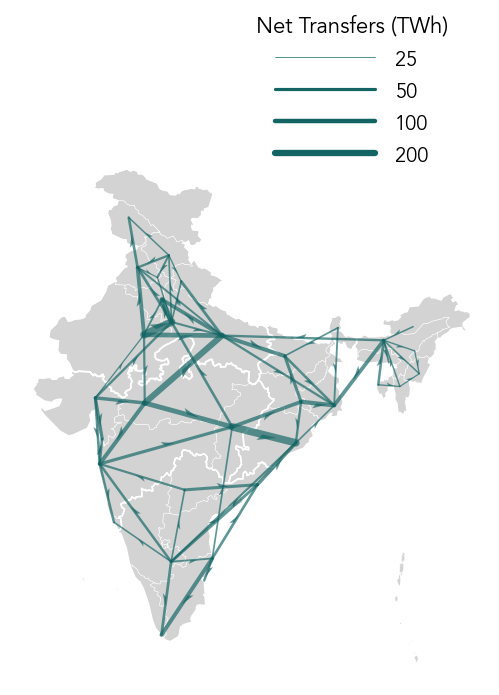

In [6]:
net_transfers_ = _load_net_transfers(tech_cost_)

period = 2050
scen   = tech_cost_.loc[tech_cost_['label'].str.contains('REF'), 'scenario'].to_numpy()[0]

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

_plot_transmission_exchange(ax, net_transfers_, load_zones_p_, period, scen)

plt.savefig(path_to_images + '/transfers.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Transmission Exchange

### System Level

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


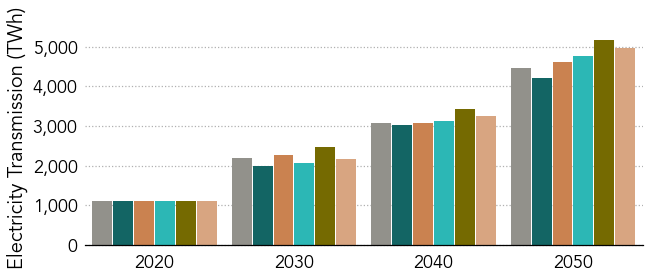

In [7]:
transfers_ = _load_transfers(tech_cost_)

fig = plt.figure(figsize = (10, 4))
_ax = plt.subplot(111)

_plot_total_transfers(_ax, transfers_, tech_cost_, legend_title = 'Technology Cost')

plt.savefig(path_to_images + r'/system_level-tranmission_exchange.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


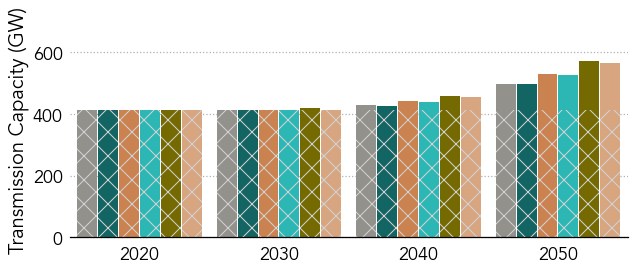

In [8]:
tx_cap_ = _load_transmission_capacity(tech_cost_)

fig = plt.figure(figsize = (10, 4))
_ax = plt.subplot(111)

_plot_transmission_capacity(_ax, tx_cap_, tech_cost_, legend_title = 'Technology Cost')

plt.savefig(path_to_images + r'/system_level-transmission_capacity.png', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

In [9]:
def _plot_transmission_exchange_by_zone(ax, df_, df_1_, scen_labels_, scen, period,
                                        title    = '',
                                        ylabel   = '',
                                        xlabel   = 'Electricity Transmission (TWh)',
                                        units    = 1e6, 
                                        legend   = True, 
                                        N_states = 30, xlim = 500):


    zones_  = df_['load_zone'].unique()
    
    width = 0.8

    ax.barh(0., 0., label  = 'Import',
                    align  = 'center',
                    color  = '#900C3F',
                    height = width, 
                    zorder = 10)
    
    ax.barh(0., 0., label  = 'Export',
                    color  = '#2cb4b4',
                    align  = 'center',
                    height = width, 
                    zorder = 10)
    
    ax.barh(0., 0., label  = 'Total',
                    align  = 'center',
                    color  = '#92918b',
                    height = width, 
                    zorder = 10)
    
    ax.barh(0., 0., label  = 'Net',
                    color  = '#136564',
                    align  = 'center',
                    height = width, 
                    zorder = 10)
    
    x_ = np.linspace(0, N_states - 1, N_states)
             
    df_pp_       = df_.loc[df_['technology'] == 'Import'].reset_index(drop = True)
    y_           = pd.DataFrame(columns = ['Import'], index = zones_)
    y_['Import'] = 0.
    
    y_.loc[df_pp_['load_zone'].values, 'Import'] = df_pp_['power_mw'].to_numpy()

    df_pp_       = df_.loc[df_['technology'] == 'Export'].reset_index(drop = True)
    z_           = pd.DataFrame(columns = ['Export'], index = zones_)
    z_['Export'] = 0.

    z_.loc[df_pp_['load_zone'].values, 'Export'] = df_pp_['power_mw'].to_numpy()

    w_ = np.absolute(y_['Import']) + np.absolute(z_['Export'])
    v_ = np.absolute(y_['Import']) - np.absolute(z_['Export'])
    idx_ = np.argsort(w_)[-N_states:]

    im_ = ax.barh(x_, y_['Import'].to_numpy()[idx_]/units,  
                  align  = 'center',
                  color  = '#900C3F',
                  height = width, 
                  zorder = 10)
    
    ex_ = ax.barh(x_, z_['Export'].to_numpy()[idx_]/units,
                  color  = '#2cb4b4',
                  align  = 'center',
                  height = width, 
                  zorder = 10)
    
    labels_ = []
    for zone in zones_[idx_]:
        abr   = df_1_.loc[df_1_['load_zone'] == zone, 'load_zone_abr'].to_numpy()[0]
        if abr == 'OR':
            abr = 'OD'
        #label = '{} ({})'.format(zone.replace("_", " "), abr)
        label = '{}'.format(abr)
        label = label.replace("Jammu Kashmir", "Jammu & Kashmir")
        label = label.replace("Dadra Nagar Haveli (DH)", "Dadra & Nagar Haveli (DHDD)")
        labels_.append(label)
        
    ax.bar_label(container  = ex_, 
                 labels     = labels_, 
                 label_type = "edge", 
                 padding    = 5, 
                 fontsize   = 18)

    ttl_ = ax.barh(x_, w_[idx_]/units,
                  color  = '#92918b',
                  align  = 'center',
                  height = width/2., 
                  zorder = 10)
    
    net_ = ax.barh(x_, v_[idx_]/units,
                   color  = '#136564',
                   align  = 'center',
                   height = width/2., 
                   zorder = 10)
        
    ax.set_yticks([], [])
    ax.set_xlabel(xlabel, fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20, labelpad = 30.)
    
    ax.xaxis.set_tick_params(labelsize = 18, left = False)
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.axvline(0, linewidth = 1.25, 
                  linestyle = '-', 
                  color     = 'k', 
                  clip_on   = False, 
                  zorder    = 10)

    if legend:
        ax.legend(loc      = 'lower right',
                  fontsize = 18,
                  frameon  = False)

    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-1, len(zones_))

    ax.set_title(title, fontsize = 22)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'x', ls = ':', lw = 1.25)

In [10]:
capacity_, tx_ = _load_state_capacity(tech_cost_)
group_cap_     = _group_capacity_technologies(capacity_, tech_labels_)


period = 2050
scen   = 'VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid'

tx_p_ = tx_.loc[(tx_['period'] == period) & (tx_['scenario'] == scen)].reset_index(drop = True)

group_cap_p_ = group_cap_.loc[(group_cap_['period'] == period) & (group_cap_['scenario'] == scen)].reset_index(drop = True)


group_cap_p_ = group_cap_p_[['load_zone', 'technology', 'capacity_mw', 'capacity_mwh']]
total_cap_ = group_cap_p_.groupby(['load_zone']).agg({'capacity_mw': 'sum', 
                                                        'capacity_mwh': 'sum'}).reset_index(drop = False)

total_cap_['capacity_gw'] = (total_cap_['capacity_mw']/1000.).round(2)

total_cap_['position']         = 1
total_cap_.loc[14, 'position'] = 0
#total_cap_.loc[7, 'position']  = 0
total_cap_.loc[24, 'position'] = 0
total_cap_.loc[4, 'position']  = 2
total_cap_.loc[5, 'position']  = 0
total_cap_.loc[13, 'position'] = 0
#total_cap_.loc[19, 'position'] = 0
total_cap_.loc[29, 'position'] = 0
total_cap_.loc[2, 'position']  = 0
total_cap_.loc[9, 'position']  = 0
total_cap_.loc[25, 'position'] = 0
total_cap_.loc[26, 'position'] = 0

# load_zones_p_.loc[30, 'longitude'] += .15
load_zones_p_.loc[29, 'longitude'] += .15

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


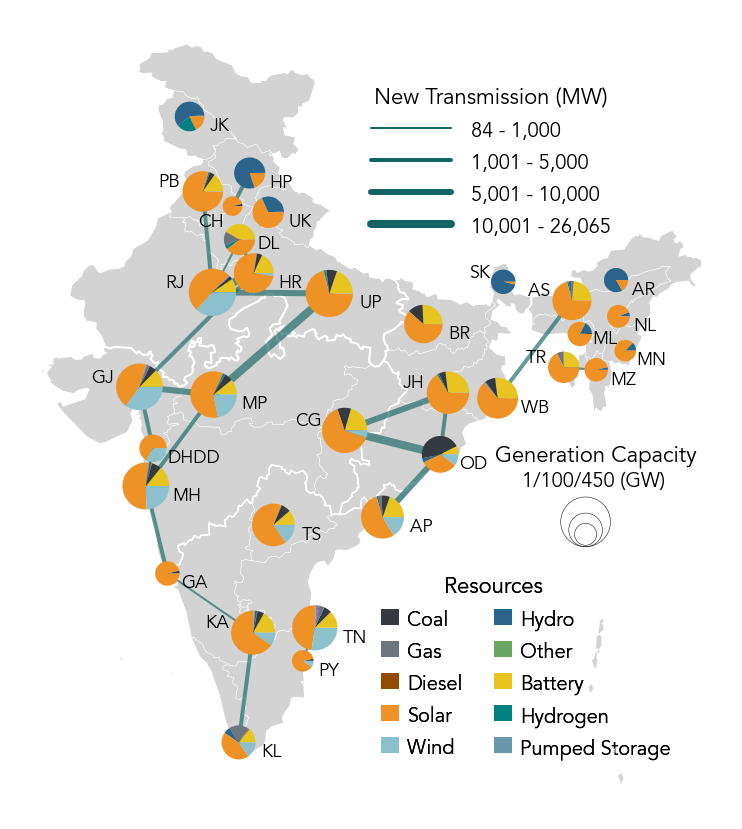

In [11]:
def _plot_new_capacity(ax, tx_, group_cap_, total_cap_, load_zones_):
    
    def __f(total):
        return np.sqrt(np.sqrt(np.sqrt(total/1e3)))/2.6
    
    #print(tx_.min(), tx_.max())
    #print(total_cap_)
    for i in range(tx_.shape[0]):

        load_zone_to_   = load_zones_.loc[load_zones_['load_zone'] == tx_.loc[i, 'load_zone_to']]
        load_zone_from_ = load_zones_.loc[load_zones_['load_zone'] == tx_.loc[i, 'load_zone_from']]

        x_ = np.concatenate([load_zone_from_['latitude'].to_numpy(), load_zone_to_['latitude'].to_numpy()], axis = 0)
        y_ = np.concatenate([load_zone_from_['longitude'].to_numpy(), load_zone_to_['longitude'].to_numpy()], axis = 0)
        
        #z = np.sqrt(np.absolute(tx_.loc[i, 'tx_mw'])/1e3)

        if tx_.loc[i, 'max_mw'] < 1000.:
            ax.plot(y_, x_, lw             = 2., 
                            zorder         = 10, 
                            color          = '#136564', 
                            solid_capstyle ='round', 
                            alpha          = .65)

        if (tx_.loc[i, 'max_mw'] < 5000.) & (tx_.loc[i, 'max_mw'] >= 1000.):
            ax.plot(y_, x_, lw             = 4, 
                            zorder         = 10, 
                            color          = '#136564', 
                            solid_capstyle ='round', 
                            alpha          = .65)

        if (tx_.loc[i, 'max_mw'] < 10000.) & (tx_.loc[i, 'max_mw'] >= 5000.):
            ax.plot(y_, x_, lw             = 6, 
                            zorder         = 10, 
                            color          = '#136564', 
                            solid_capstyle ='round', 
                            alpha          = .65)

        if tx_.loc[i, 'max_mw'] >= 10000.:
            ax.plot(y_, x_, lw             = 8, 
                            zorder         = 10, 
                            color          = '#136564', 
                            solid_capstyle ='round', 
                            alpha          = .65)

    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    for i in range(total_cap_.shape[0]):

        load_zone_ = load_zones_.loc[load_zones_['load_zone'] == total_cap_.loc[i, 'load_zone']]
        cap_       = group_cap_.loc[group_cap_['load_zone'] == total_cap_.loc[i, 'load_zone'], ['technology', 'capacity_mw']]
        abr        = load_zone_['load_zone_abr'].to_numpy()[0]
        total      = total_cap_.loc[i, 'capacity_mw']
        totalp     = int(total)
        width      = __f(total)

        axp_ = inset_axes(ax, width          = width, 
                              height         = width, 
                              bbox_to_anchor = (load_zone_['longitude'], load_zone_['latitude']),
                              loc            = 10, 
                              bbox_transform = ax.transData, 
                              borderpad      = 0)

        if total_cap_.loc[i, 'position'] == 0:
            axp_.set_ylabel(f'{abr}', fontsize = 18, labelpad = 8, rotation = 0)
        if total_cap_.loc[i, 'position'] == 1:
            if (abr == 'ML') | (abr == 'DL'):
                axp_.set_ylabel(f'{abr}', fontsize = 18, labelpad = 10, rotation = 0, y = .65)
            elif abr == 'DH':
                axp_.set_ylabel(f'DHDD', fontsize = 18, labelpad = 24, rotation = 0)
            elif abr == 'OR':
                axp_.set_ylabel(f'OD', fontsize = 18, labelpad = 10, rotation = 0)
            else:
                axp_.set_ylabel(f'{abr}', fontsize = 18, labelpad = 12, rotation = 0)
            axp_.yaxis.set_label_position('right') 
        if total_cap_.loc[i, 'position'] == 2:
            axp_.set_xlabel(f'{abr}', fontsize = 18, labelpad = -6, x = -.4)
        if total_cap_.loc[i, 'position'] == 3:
            axp_.set_xlabel(f'{abr}', fontsize = 18, labelpad = -1.5)
            axp_.xaxis.set_label_position('top') 

        wedges, texts = axp_.pie(cap_['capacity_mw']/total,
                                 colors     = [tech_labels_.loc[tech_labels_['group'] == tech, 'group_color'].to_numpy()[0] for tech in cap_['technology']])
    
        for w in wedges:
            w.set_linewidth(.001)
            w.set_edgecolor('k')

    _nothern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _northeastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _western.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _southern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _eastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _map.plot(ax = ax, zorder = 8, color = 'lightgray', lw = 0.5, edgecolor = 'white')
    
    x = 20.5
    y = 7.5
    
    ax.scatter(71.75 + x, 9.5 + y, s = 1250*__f(1000), zorder = 10, c = 'None', edgecolor = 'k', lw = .5)
    ax.scatter(71.75 + x, 9.68 + y, s = 2100*__f(15000), zorder = 10, c = 'None', edgecolor = 'k', lw = .5)
    ax.scatter(71.75 + x, 10.01 + y, s = 3000*__f(450000), zorder = 10, c = 'None', edgecolor = 'k', lw = .5)

    ax.annotate('Generation Capacity', (67.75 + x, 12.5 + y), fontsize = 22)
    ax.annotate('1/100/450 (GW)', (68.95 + x, 11.5 + y), fontsize = 20)
    # ax.annotate('500', (70.5 + x, 11.2 + y), fontsize = 19)
    # ax.annotate('100', (70.5 + x, 10.55 + y), fontsize = 19)
    # ax.annotate('1', (70.9 + x, 9.9 + y), fontsize = 19)

    # axp_ = inset_axes(ax, width          = .75, 
    #                       height         = .75, 
    #                       bbox_to_anchor = (87.5, 12.5),
    #                       loc            = 10, 
    #                       bbox_transform = ax.transData, 
    #                       borderpad      = 0)

#     axp_.set_title('Existing Capacity (MW)', size = 20, y = 1.375)
#     axp_.pie([1, 1, 1, 1, 1, 1, 1], 
#              wedgeprops    = {'edgecolor': 'black', 'linewidth': .1},
#              colors        = ['#343a40', '#6c757d', '#924B00', '#ef9226', '#8dc0cd', '#6ba661', '#2a648a'],
#              labels        = ['Coal', 'Gas', 'Disel', 'Solar', 'Wind', 'Other', 'Hydro'], 
#              labeldistance = 1.5, 
#              textprops     = {'fontsize': 18})

    line1 = Line2D([], [], color = '#136564', lw = 2, solid_capstyle ='round')
    line2 = Line2D([], [], color = '#136564', lw = 4, solid_capstyle ='round')
    line3 = Line2D([], [], color = '#136564', lw = 6, solid_capstyle ='round')
    line4 = Line2D([], [], color = '#136564', lw = 8, solid_capstyle ='round')

    legend1 = ax.legend((line1, line2, line3, line4), ('84 - 1,000', '1,001 - 5,000', '5,001 - 10,000', '10,001 - 26,065'), 
                           title_fontsize = 22,
                           title          = 'New Transmission (MW)',
                           handlelength   = 4.,
                           handletextpad  = 1.,
                           labelspacing   = .5,
                           frameon        = False, 
                           bbox_to_anchor = (0.475, 0.925), 
                           prop           = {'size': 20})

    s0 = Line2D([], [], color = '#343a40', lw = 16)
    s1 = Line2D([], [], color = '#6c757d', lw = 16)
    s2 = Line2D([], [], color = '#924B00', lw = 16)
    s3 = Line2D([], [], color = '#ef9226', lw = 16)
    s4 = Line2D([], [], color = '#8dc0cd', lw = 16)
    s5 = Line2D([], [], color = '#2a648a', lw = 16)
    s6 = Line2D([], [], color = '#6ba661', lw = 16)
    s7 = Line2D([], [], color = '#e7c41f', lw = 16)
    s8 = Line2D([], [], color = 'teal', lw =  16)
    s9 = Line2D([], [], color = '#6a96ac', lw =  16)

    x_ = (s0, s1, s2, s3, s4, s5, s6, s7, s8, s9)
    y_ = ('Coal', 'Gas', 'Diesel', 'Solar', 'Wind',  'Hydro', 'Other', 'Battery', 'Hydrogen', 'Pumped Storage')
    legend2 = ax.legend(x_, y_,
                        title          = r'Resources            ',
                        title_fontsize = 22,
                        handlelength   = .1,
                        ncol           = 2,
                        bbox_to_anchor = (.5, .325),
                        frameon        = False,
                        prop           = {'size': 20})
    
    ax.add_artist(legend1)
    ax.add_artist(legend2)
  
fig, ax = plt.subplots(1, 1, figsize = (17, 15))

_plot_new_capacity(ax, tx_p_, group_cap_p_, total_cap_, load_zones_p_)

plt.savefig(path_to_images + '/new_capacity.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.savefig(path_to_images + '/new_capacity.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

### Zone Level

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


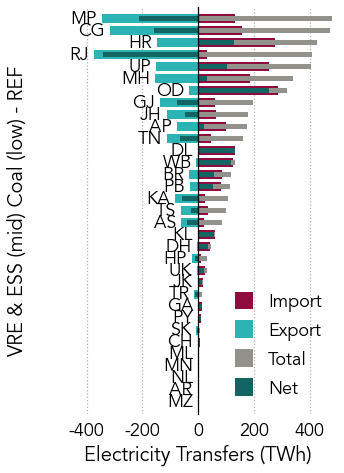

In [12]:
transfers_ = _load_transfers(tech_cost_)

#scen = 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_ICEDmid'
period = 2050

scen  = tech_cost_.loc[tech_cost_['label'].str.contains('REF'), 'scenario'].to_numpy()[0]
label = tech_cost_.loc[tech_cost_['label'].str.contains('REF'), 'label'].to_numpy()[0]
    
fig = plt.figure(figsize = (5, 7.5))
_ax = plt.subplot(111)

transfers_p_ = transfers_.loc[(transfers_['scenario'] == scen) & (transfers_['period'] == period) ].reset_index(drop = True)
    
_plot_transmission_exchange_by_zone(_ax, transfers_p_, load_zones_p_, tech_cost_, scen, period, 
                                    ylabel   = f'{label}', 
                                    xlabel   = 'Electricity Transfers (TWh)',
                                    N_states = 33)

plt.savefig(path_to_images + r'/zone_level-transmission_exchange.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [13]:
net_transfers_ = _load_net_transfers(tech_cost_)
transfers_     = _load_transfers(tech_cost_)
tx_cap_        = _load_transmission_capacity(tech_cost_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power

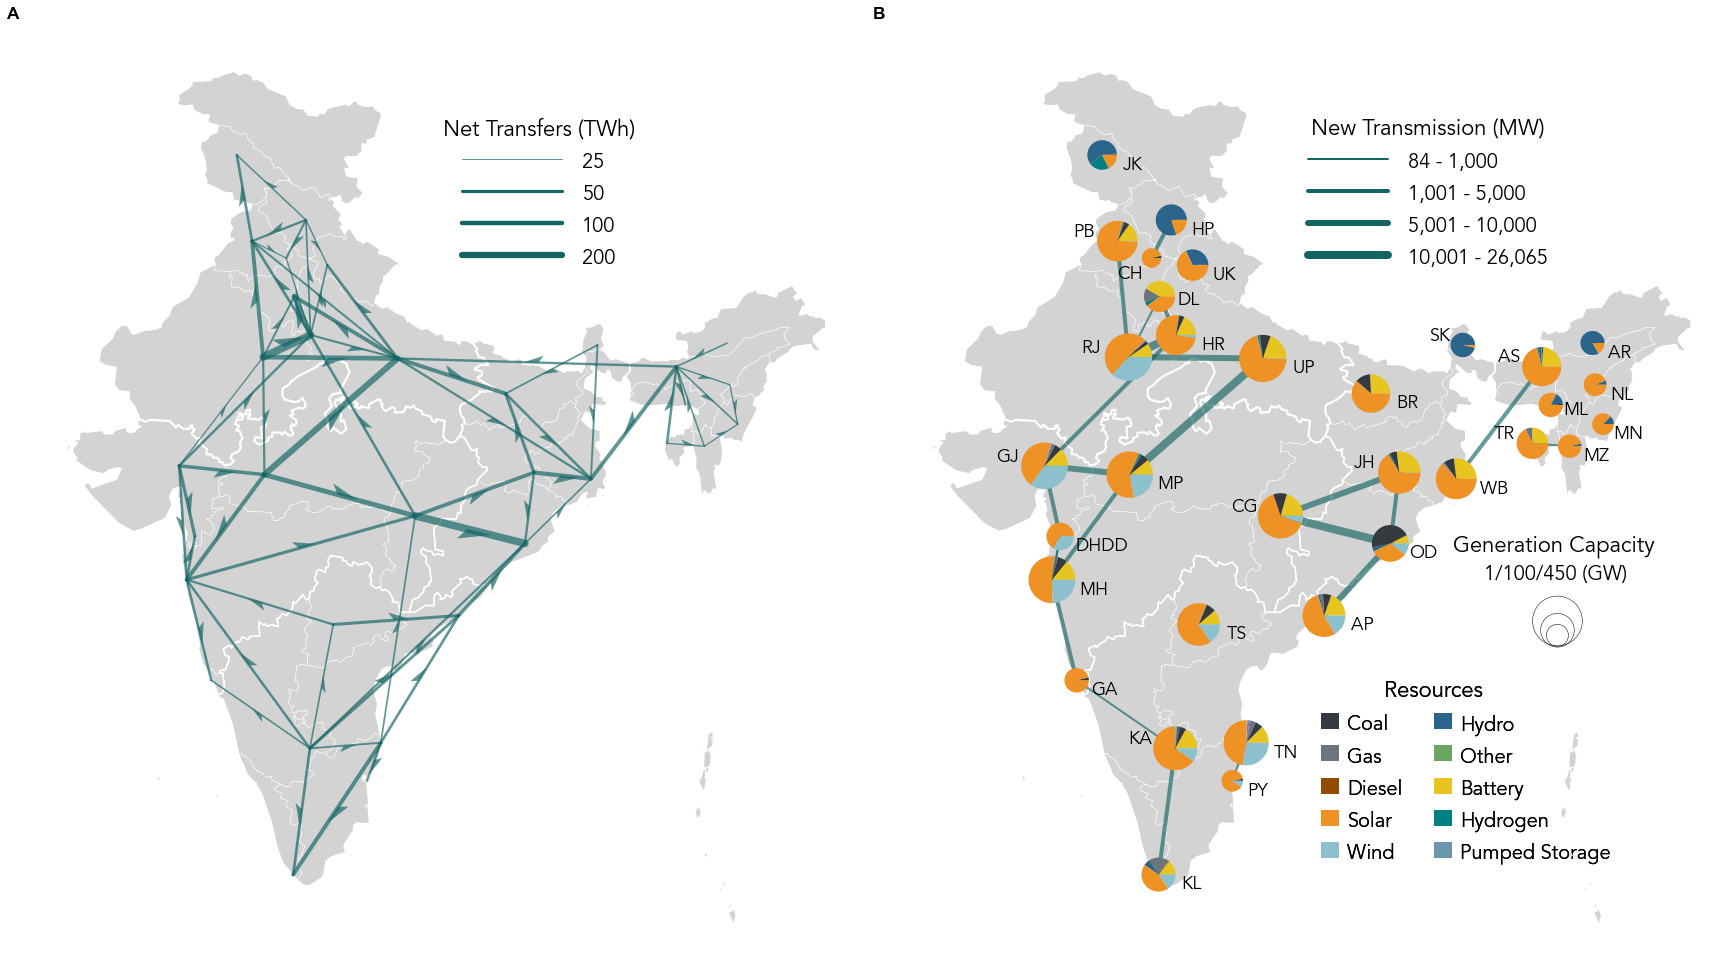

In [14]:
period = 2050
scen   = tech_cost_.loc[tech_cost_['label'].str.contains('REF'), 'scenario'].to_numpy()[0]
ylabel = tech_cost_.loc[tech_cost_['label'].str.contains('REF'), 'label'].to_numpy()[0]


fig, _ax = plt.subplot_mosaic([['A', 'A', 'B', 'B'],
                               ['A', 'A', 'B', 'B'],
                               ['A', 'A', 'B', 'B']], layout      = 'constrained', 
                                                     figsize     = (24, 15), 
                                                     gridspec_kw = {'width_ratios': [1, 1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')
    
_plot_transmission_exchange(_ax['A'], net_transfers_, load_zones_p_, period, scen)

_plot_new_capacity(_ax['B'], tx_p_, group_cap_p_, total_cap_, load_zones_p_)


plt.savefig(path_to_images + r'/zone_level-transmission_exchange-1.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.savefig(path_to_images + r'/zone_level-transmission_exchange-1.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

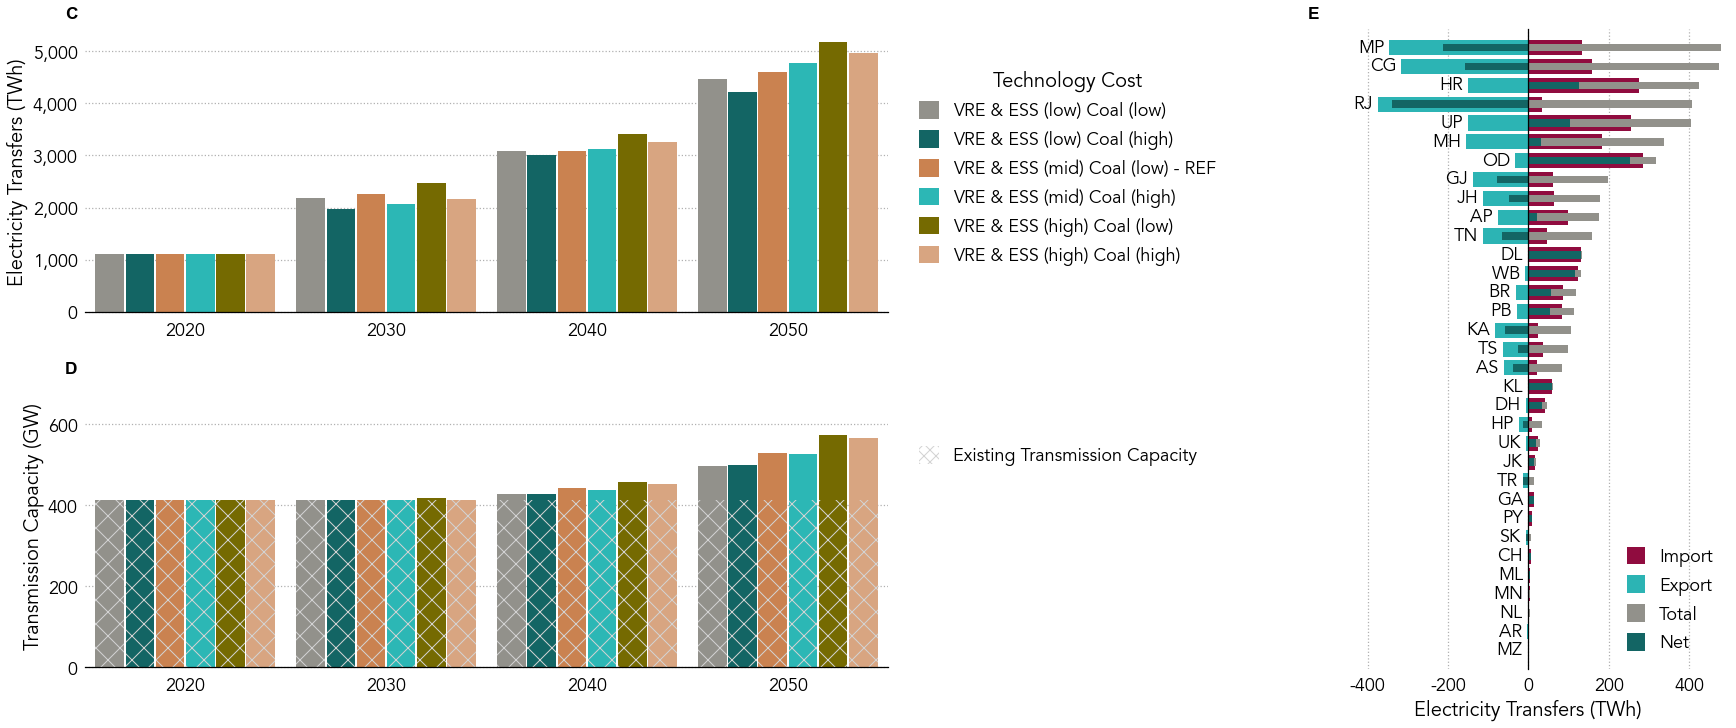

In [15]:
period = 2050
scen   = tech_cost_.loc[tech_cost_['label'].str.contains('REF'), 'scenario'].to_numpy()[0]
ylabel = tech_cost_.loc[tech_cost_['label'].str.contains('REF'), 'label'].to_numpy()[0]


fig, _ax = plt.subplot_mosaic([['C', 'C', '', 'E'],
                               ['D', 'D', '', 'E']], layout      = 'constrained', 
                                                     figsize     = (24, 10), 
                                                     gridspec_kw = {'width_ratios': [1, 1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

_plot_total_transfers(_ax['C'], transfers_, tech_cost_, 
                      legend_title = 'Technology Cost', 
                      ylabel       = 'Electricity Transfers (TWh)')


handles, labels = _ax['C'].get_legend_handles_labels()
fig.legend(handles, labels, title = 'Technology Cost', 
                            loc            = (0.525, 0.625),
                            title_fontsize = 20,
                            frameon        = False,
                            handlelength   = 1.125,
                            ncol           = 1,
                            prop           = {'size': 18})

_plot_transmission_capacity(_ax['D'], tx_cap_, tech_cost_, 
                            legend_title = 'Technology Cost')

handles, labels = _ax['D'].get_legend_handles_labels()
fig.legend(handles, labels, loc          = (0.525, 0.35),
                            frameon      = False,
                            handlelength = 1.125,
                            ncol         = 1,
                            prop         = {'size': 18})

_plot_transmission_exchange_by_zone(_ax['E'], transfers_p_, load_zones_p_, tech_cost_, scen, period, 
                                    ylabel   = '', 
                                    xlabel   = 'Electricity Transfers (TWh)',
                                    N_states = 33, xlim = 500)

_ax[''].axis('off')

plt.savefig(path_to_images + r'/zone_level-transmission_exchange-2.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.savefig(path_to_images + r'/zone_level-transmission_exchange-2.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

# Mosaic

In [16]:
transmission_ = _load_transmission(scen_labels_)

NameError: name '_load_transmission' is not defined

In [ ]:
scens_   = transmission_['scenario'].unique()
periods_ = transmission_['period'].unique()
letters_ = [list(string.ascii_lowercase)[i*len(periods_):i*len(periods_) + len(periods_)] 
            for i in range(len(scens_))]

fig, _ax = plt.subplot_mosaic(letters_, layout      = 'constrained', 
                                        sharey      = True,
                                        sharex      = True,
                                        figsize     = (.75*len(letters_[0])*len(periods_), 5*len(letters_)), 
                                        gridspec_kw = {'width_ratios': [1]*len(letters_[0])})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')

    
    
n      = len(letters_)*len(letters_[0])
k      = 1
legend = False

for i in range(len(letters_)):
    for j in range(len(letters_[i])):
        
        scen   = scens_[i]
        period = int(periods_[j])
        label  = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0]

        if i == 0:
            title = f'{period}'
        else:
            title = ''
        
        if j == 0: 
            ylabel = label
        else: 
            ylabel = ''
            
        if i == len(letters_) - 1: 
            xlabel = 'Electricity Transmission (TWh)'
        else: 
            xlabel = ''
                    
        if k == n: 
            legend = True
        else:
            k += 1
            
        _plot_transmission_exchange_by_zone(_ax[letters_[i][j]], transmission_.copy(), 
                                            scen_labels_, scen, period, 
                                            title    = title, 
                                            ylabel   = ylabel, 
                                            xlabel   = xlabel,
                                            legend   = legend, 
                                            N_states = 20)

plt.savefig(path_to_images + r'/zone_level-transmission_exchange.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()